In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.model_selection import train_test_split
import pandas as pd
from matplotlib import gridspec
from scipy import stats
from sklearn import preprocessing
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

# restart kernel
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True

Using TensorFlow backend.
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/shared_env/l

In [4]:
datafile="/data0/users/bpnachman/Gaia/GD1-circle-140-30-15.pkl"
gaiadata=np.load(datafile,allow_pickle=True)
gaiadata2=np.array(gaiadata[['pmdec','pmra','dec','ra','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag', 'streammask']].astype('float32'))
gaiadata2 = np.vstack([gaiadata2[:,0].T,
           gaiadata2[:,1].T,
           gaiadata2[:,2].T,
           gaiadata2[:,3].T,
           (gaiadata2[:,5]-gaiadata2[:,6]).T,
           gaiadata2[:,4].T, 
            gaiadata2[:,7].T]).T
gaiadata2 = gaiadata2[np.sum(np.isnan(gaiadata2),axis=1)==0]
center_dec=0.5*(np.max(gaiadata2[:,2])+np.min(gaiadata2[:,2]))
center_ra=0.5*(np.max(gaiadata2[:,3])+np.min(gaiadata2[:,3]))
radius=np.sqrt((gaiadata2[:,2]-center_dec)**2+(gaiadata2[:,3]-center_ra)**2)
gaiadata2=gaiadata2[radius<15]
np.random.shuffle(gaiadata2)

In [5]:
gaiadata3=np.array(gaiadata[gaiadata['streammask']==1][['pmdec','pmra','dec','ra','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag', 'streammask']].astype('float32'))
gaiadata3 = np.vstack([gaiadata3[:,0].T,
           gaiadata3[:,1].T,
           gaiadata3[:,2].T,
           gaiadata3[:,3].T,
           (gaiadata3[:,5]-gaiadata3[:,6]).T,
           gaiadata3[:,4].T, 
           gaiadata3[:, 7].T]).T
gaiadata3 = gaiadata3[np.sum(np.isnan(gaiadata3),axis=1)==0]
radius=np.sqrt((gaiadata3[:,2]-center_dec)**2+(gaiadata3[:,3]-center_ra)**2)
gaiadata3=gaiadata3[radius<15]
np.random.shuffle(gaiadata3)

In [6]:
gaiadata2_no_gd1 = np.array(gaiadata[gaiadata['streammask']==0][['pmdec','pmra','dec','ra','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag', 'streammask']].astype('float32'))
gaiadata2_no_gd1 = np.vstack([gaiadata2_no_gd1[:,0].T,
           gaiadata2_no_gd1[:,1].T,
           gaiadata2_no_gd1[:,2].T,
           gaiadata2_no_gd1[:,3].T,
           (gaiadata2_no_gd1[:,5]-gaiadata2_no_gd1[:,6]).T,
           gaiadata2_no_gd1[:,4].T, 
            gaiadata2_no_gd1[:, 7].T]).T
gaiadata2_no_gd1 = gaiadata2_no_gd1[np.sum(np.isnan(gaiadata2_no_gd1),axis=1)==0]
radius=np.sqrt((gaiadata2_no_gd1[:,2]-center_dec)**2+(gaiadata2_no_gd1[:,3]-center_ra)**2)
gaiadata2_no_gd1=gaiadata2_no_gd1[radius<15]
np.random.shuffle(gaiadata2_no_gd1)                            

In [7]:
gaiadata.keys()

Index(['source_id', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax',
       'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec',
       'pmdec_error', 'phot_g_mean_mag', 'phot_bp_mean_mag',
       'phot_rp_mean_mag', 'bp_rp', 'radial_velocity', 'radial_velocity_error',
       'teff_val', 'streammask'],
      dtype='object')

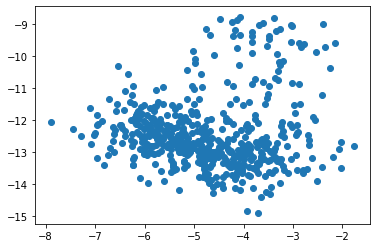

In [8]:
plt.scatter(gaiadata3[:,1],gaiadata3[:,0])

Text(0, 0.5, '$\\mu_\\delta$ [$\\mu$as/year]')

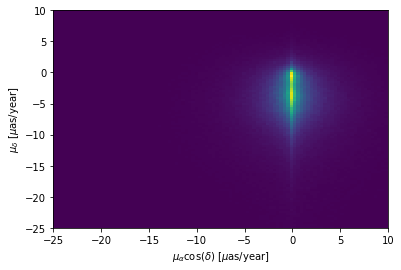

In [9]:
_,_,_,_=plt.hist2d(gaiadata2[:,1]*np.cos(gaiadata2[:,2]),gaiadata2[:,0],bins=[np.linspace(-25,10,100),np.linspace(-25,10,100)])
plt.xlabel(r"$\mu_\alpha\cos(\delta)$ [$\mu$as/year]")
plt.ylabel(r"$\mu_\delta$ [$\mu$as/year]")

Text(0, 0.5, '$\\delta$ [degrees]')

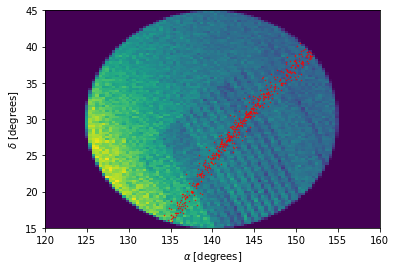

In [10]:
_,_,_,_=plt.hist2d(gaiadata2[:,3],gaiadata2[:,2],bins=[np.linspace(120,160,100),np.linspace(15,45,100)])
plt.scatter(gaiadata3[:,3],gaiadata3[:,2],color='red',s=0.2)
plt.xlabel(r"$\alpha$ [degrees]")
plt.ylabel(r"$\delta$ [degrees]")

Text(0, 0.5, '$\\delta$ [degrees]')

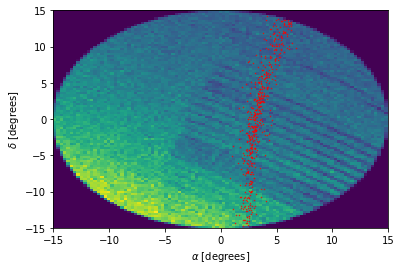

In [11]:
X = gaiadata2[:,3]-center_ra
Y = gaiadata2[:,2]-center_dec

Xs = gaiadata3[:,3]-center_ra
Ys = gaiadata3[:,2]-center_dec

theta = -0.5
Xr = X*np.cos(theta) + Y*np.sin(theta)
Yr = -X*np.sin(theta) + Y*np.cos(theta)
Xsr = Xs*np.cos(theta) + Ys*np.sin(theta)
Ysr = -Xs*np.sin(theta) + Ys*np.cos(theta)

_,_,_,_=plt.hist2d(Xr,Yr,bins=[np.linspace(-15,15,100),np.linspace(-15,15,100)])
plt.scatter(Xsr,Ysr,color='red',s=0.2)
plt.xlabel(r"$\alpha$ [degrees]")
plt.ylabel(r"$\delta$ [degrees]")

Text(0.5, 0, 'Rotated $\\delta$-$\\alpha$ space')

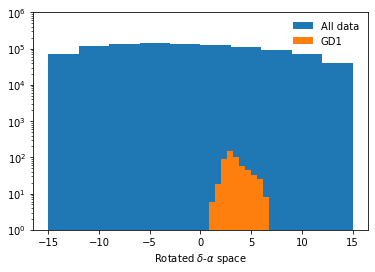

In [12]:
plt.hist(Xr,label="All data")
plt.hist(Xsr,label="GD1")
plt.yscale("log")
plt.legend(frameon=False)
plt.ylim([1,1e6])
plt.xlabel(r"Rotated $\delta$-$\alpha$ space")

Text(0.5, 0, '$\\mu_\\alpha\\cos(\\delta)$ [$\\mu$as/year]')

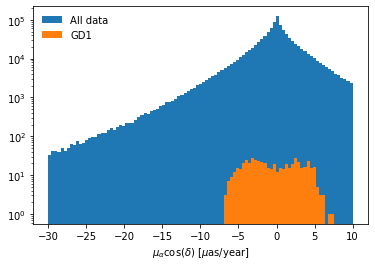

In [13]:
_,_,_=plt.hist(gaiadata2[:,1]*np.cos(gaiadata2[:,2]),bins=np.linspace(-30,10,100),label="All data")
_,_,_=plt.hist(gaiadata3[:,1]*np.cos(gaiadata3[:,2]),bins=np.linspace(-30,10,100),label="GD1")
plt.legend(frameon=False)
plt.yscale("log")
plt.xlabel(r"$\mu_\alpha\cos(\delta)$ [$\mu$as/year]")

Text(0.5, 0, '$\\mu_\\delta$ [$\\mu$as/year]')

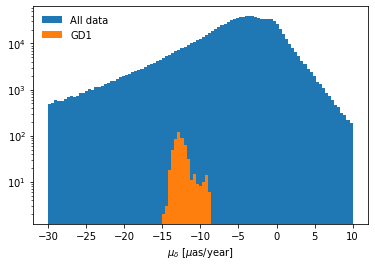

In [14]:
_,_,_=plt.hist(gaiadata2[:,0],bins=np.linspace(-30,10,100),label="All data")
_,_,_=plt.hist(gaiadata3[:,0],bins=np.linspace(-30,10,100),label="GD1")
plt.legend(frameon=False)
plt.yscale("log")
plt.xlabel(r"$\mu_\delta$ [$\mu$as/year]")

In [15]:
def build_data_arrays(SR, SB, GD1):
    X = SR[:,3]-center_ra
    Y = SR[:,2]-center_dec

    Xb = SB[:,3]-center_ra
    Yb = SB[:,2]-center_dec

    Xs = GD1[:,3]-center_ra
    Ys = GD1[:,2]-center_dec

    SR = np.c_[SR[:,0],SR[:,1],X, Y, SR[:,4],SR[:,5], SR[:,6]]
    SB = np.c_[SB[:,0],SB[:,1],Xb, Yb, SB[:,4],SB[:,5], SB[:,6]]
    GD1 = np.c_[GD1[:,0],GD1[:,1],Xs, Ys, GD1[:,4],GD1[:,5], GD1[:,6]]
    
    return SR, SB, GD1

In [ ]:
def build_model(SR, SB, stream, num_models, all_data, plot_cuts = False):
    X = np.concatenate([SR,SB,stream])
    Y = np.concatenate([np.ones(len(SR)),np.zeros(len(SB)),2.*np.ones(len(stream))])
    X_scaled = preprocessing.scale(X[:, :6])
    all_data_scaled = preprocessing.scale(all_data[:, :6])
    X_scaled = np.c_[X_scaled, X[:, 6]]
    stream_scaled = X_scaled[Y==2]
    X_scaled = X_scaled[Y<2]
    Y = Y[Y<2]
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.5)

#     tpr_arr = []
#     fpr_arr = []
#     stream_background_x_arr = []
#     stream_background_y_arr = []

    for i in range(num_models):

        model = Sequential()
        model.add(Dense(64, input_dim=5, activation='relu')) 
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        history = model.fit(X_train[:,1:6],Y_train, epochs=20, batch_size=200,validation_data=(X_test[:,1:6],Y_test), verbose = 0) 

        preds = model.predict(X_test[:,1:6], batch_size=int(0.1*len(X_test)))
        preds_SR = preds[(Y_test == 1) * (X_test[:, 6] == 0)]
        
        preds_all = model.predict(all_data_scaled[:, 1:6], batch_size = int(0.1*len(all_data_scaled))) #0.01

        preds_stream = model.predict(stream_scaled[:,1:6], batch_size=int(0.1*len(stream_scaled)))

#         fpr, tpr, thresholds = roc_curve(np.concatenate([np.zeros(len(preds_SR)),np.ones(len(preds_stream))]), np.concatenate([preds_SR,preds_stream]))
#         fpr2, tpr2, thresholds2 = roc_curve(Y_test, preds)
                
#         tpr_arr.append(tpr)
#         fpr_arr.append(fpr)
#         stream_background_x_arr.append(tpr2)
#         stream_background_y_arr.append(fpr2)
        
#         chi_squared_arr = []
        cuts = [0.,0.5,0.9,0.99]
#         prev_bins_sizes = []
        if plot_cuts:
            for i in range(len(cuts)):
                cut = cuts[i]
                print(cut)
#                 X_pass = X_test[(Y_test==1)*(preds[:,0] > np.quantile(preds[Y_test==1],[cut])[0])]
#                 print(np.quantile(preds[Y_test==1], [cut]))
#                 print(preds_stream[:,0] > np.quantile(preds_all[Y_test==1],[cut])[0])
#                 print(stream_scaled[preds_stream[:,0] > np.quantile(preds_all[Y_test==1],[cut])[0]])
                X_pass_stream = stream_scaled[preds_stream[:,0] > np.quantile(preds[Y_test==1],[cut])[0]]
            
                print((preds[:,0] > np.quantile(preds[Y_test==1],[cut])[0]))
                X_pass_all = all_data_scaled[(preds_all[:,0] > np.quantile(preds[Y_test==1],[cut])[0])]
                plt.figure(figsize=(6,6))
                plt.hist(X_pass_all[:,0], label = "All data", bins = np.linspace(-20, 10, 30))
                plt.hist(X_pass_stream[:,0], label = "GD1", bins = np.linspace(-20, 10, 30))
                plt.yscale("log")
                plt.show()
#                 plt.figure(figsize=(6,6))
#                 bin_sizes, _, _ = plt.hist(X_pass[:,1], label = "All data", alpha = 0.5, bins = np.linspace(-2, 2, 20))
# #                 print(bin_sizes)
                
#                 if i > 0:
#                     chi_squared_arr.append(sum([((b - p)**2)/p for b, p in zip(bin_sizes, prev_bin_sizes)]))

#                 #plt.hist(X_pass[:,1],label="All data",alpha=0.5,bins=np.linspace(-2,2,20))
#                 plt.hist(X_pass_stream[:,1],label="GD1",alpha=0.5,bins=np.linspace(-2,2,20))
#                 plt.yscale("log")
#                 plt.legend(frameon=False,title=str(100*cut)+"th percentile cut",fontsize=20)
#                 plt.ylim([1,1e6])
#                 plt.ylabel("Counts",fontsize=20)
#                 plt.xlabel("Proper motion RA",fontsize=20)
#                 plt.show()
#                 if i == 0:
#                     prev_bin_sizes = bin_sizes
    
#     return tpr_arr, fpr_arr, chi_squared_arr

In [18]:
threshold_arr_size = 10000

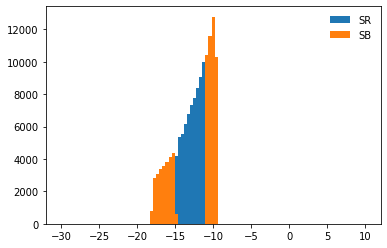

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/opt/anaconda3/envs/shared_env/lib/python3.6/site-pa

0.0
[ True  True  True ...  True  True  True]


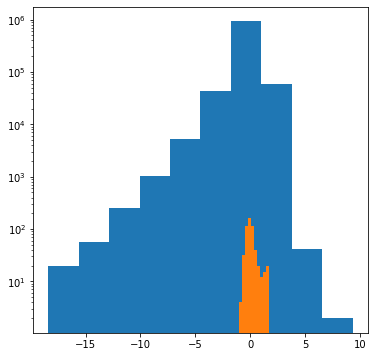

0.5
[ True False False ...  True False False]


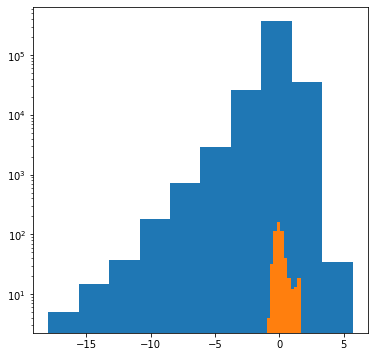

0.9
[False False False ... False False False]


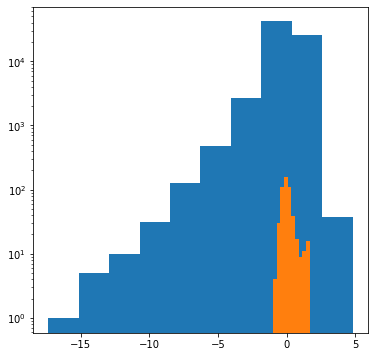

0.99
[False False False ... False False False]


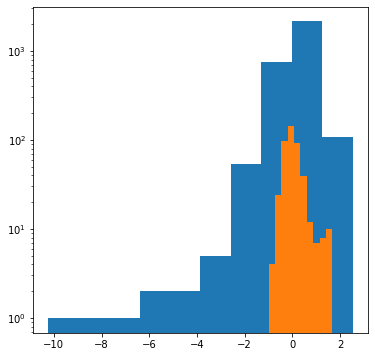

In [19]:
SR = gaiadata2[(gaiadata2[:,0] > -15)*(gaiadata2[:,0] < -11)]
SB = gaiadata2[(gaiadata2[:,0] > -18)*(gaiadata2[:,0] < -15)+(gaiadata2[:,0] > -11)*(gaiadata2[:,0] < -9.5)]

if len(SR) >= threshold_arr_size:
    SR, SB, GD1 = build_data_arrays(SR, SB, gaiadata3)
    _,_,_=plt.hist(SR[:,0],bins=np.linspace(-30,10,100),label="SR")
    _,_,_=plt.hist(SB[:,0],bins=np.linspace(-30,10,100),label="SB")
    plt.legend(frameon=False)
    plt.show()
    build_model(SR, SB, GD1, 1, gaiadata2, True)

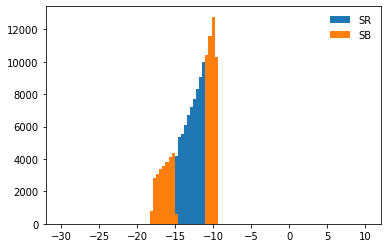

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/opt/anaconda3/envs/shared_env/lib/python3.6/site-pa

0.0
[ True  True  True ...  True  True  True]


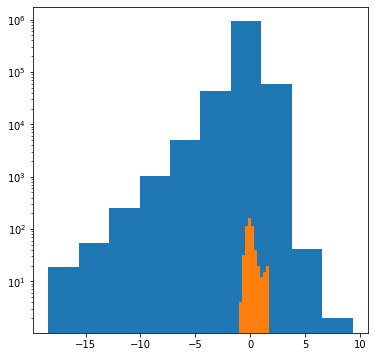

0.5
[False  True False ... False  True False]


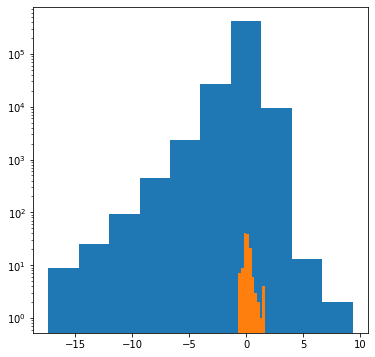

0.9
[False False False ... False False False]


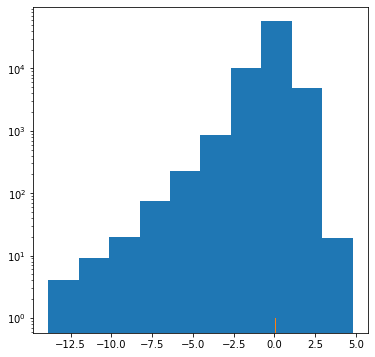

0.99
[False False False ... False False False]


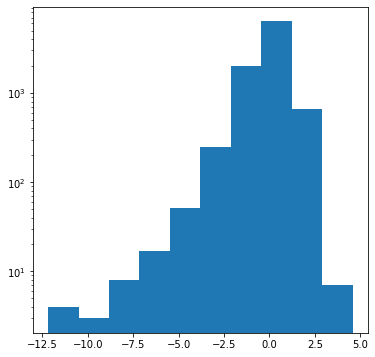

In [20]:
SR = gaiadata2_no_gd1[(gaiadata2_no_gd1[:,0] > -15)*(gaiadata2_no_gd1[:,0] < -11)]
SB = gaiadata2_no_gd1[(gaiadata2_no_gd1[:,0] > -18)*(gaiadata2_no_gd1[:,0] < -15)+(gaiadata2_no_gd1[:,0] > -11)*(gaiadata2_no_gd1[:,0] < -9.5)]

if len(SR) >= threshold_arr_size:
    SR, SB, GD1 = build_data_arrays(SR, SB, gaiadata3)
    _,_,_=plt.hist(SR[:,0],bins=np.linspace(-30,10,100),label="SR")
    _,_,_=plt.hist(SB[:,0],bins=np.linspace(-30,10,100),label="SB")
    plt.legend(frameon=False)
    plt.show()
    build_model(SR, SB, GD1, 1, gaiadata2, True)

In [ ]:
def calc_diff(SR, SB):
    return abs(len(SR) - len(SB))

In [ ]:
def find_SR_SB_pointers(pointers, increment, data_arr):
    SR = data_arr[(data_arr[:,0] > pointers[1])*(data_arr[:,0] < pointers[2])]
    SB = data_arr[(data_arr[:,0] > pointers[0])*(data_arr[:,0] < pointers[1]) + (data_arr[:,0] > pointers[2])*(data_arr[:,0] < pointers[3])]

    previous_diff = calc_diff(SR, SB)
    prev_SR, prev_SB = SR, SB
    curr_diff = previous_diff
    bottom_bool = False
    top_bool = True

    while curr_diff <= previous_diff and pointers[3] < end_point:
        previous_diff, prev_SR, prev_SB = curr_diff, SR, SB
        if bottom_bool:
            pointers[0] = max(start_point, pointers[0] - increment)
        else:
            pointers[3] = min(end_point, pointers[3] + increment)
        bottom_bool, top_bool = top_bool, bottom_bool
        SR = data_arr[(data_arr[:,0] > pointers[1])*(data_arr[:,0] < pointers[2])]
        SB = data_arr[(data_arr[:,0] > pointers[0])*(data_arr[:,0] < pointers[1]) + (data_arr[:,0] > pointers[2])*(data_arr[:,0] < pointers[3])]
        curr_diff = calc_diff(SR, SB)

    return prev_SR, prev_SB

In [ ]:
start_point = min(gaiadata2[:,0])
pointers = np.zeros(4)
signal_size = 4
signal_increment = 2
sb_start_diff = 0.5
pointers[0] = start_point
pointers[1] = start_point + sb_start_diff
pointers[2] = pointers[1] + signal_size
pointers[3] = pointers[2] + sb_start_diff
end_point = max(gaiadata2[:,0])
auc_arr = np.array([])
region_mids = np.array([])
threshold_arr_size = 10000
while pointers[3] <= end_point:
    SR, SB = find_SR_SB_pointers(pointers, sb_start_diff, gaiadata2)

    if len(SR) >= threshold_arr_size:
        SR, SB, GD1 = build_data_arrays(SR, SB, gaiadata3)
#         _,_,_=plt.hist(SR[:,0],bins=np.linspace(-30,10,100),label="SR")
#         _,_,_=plt.hist(SB[:,0],bins=np.linspace(-30,10,100),label="SB")
#         plt.legend(frameon=False)
#         plt.show()
        tpr_gd1_1, fpr_gd1_1, chi_arr = build_model(SR, SB, GD1, 1, True)
        print((pointers[1] + pointers[2])/2, chi_arr)
#         for x, y in zip(tpr_gd1_1, fpr_gd1_1):
#             plt.plot(x, x/y**0.5)
#             plt.show()
#         auc_arr = np.append(auc_arr, auc(fpr_gd1_2[0], tpr_gd1_2[0]))
#         region_mids = np.append(region_mids, (pointers[1] + pointers[2])/2)
    pointers[1] += signal_increment
    pointers[2] += signal_increment
    pointers[0] = pointers[1] - sb_start_diff
    pointers[3] = pointers[2] + sb_start_diff

In [ ]:
start_point = min(gaiadata2[:,0])
pointers = np.zeros(4)
signal_size = 4
signal_increment = 2
sb_start_diff = 0.5
pointers[0] = start_point
pointers[1] = start_point + sb_start_diff
pointers[2] = pointers[1] + signal_size
pointers[3] = pointers[2] + sb_start_diff
end_point = max(gaiadata2[:,0])
auc_arr = np.array([])
region_mids = np.array([])
threshold_arr_size = 10000
while pointers[3] <= end_point:
    SR, SB = find_SR_SB_pointers(pointers, sb_start_diff, gaiadata2_no_gd1)

    if len(SR) >= threshold_arr_size:
        SR, SB, GD1 = build_data_arrays(SR, SB, gaiadata3)
#         _,_,_=plt.hist(SR[:,0],bins=np.linspace(-30,10,100),label="SR")
#         _,_,_=plt.hist(SB[:,0],bins=np.linspace(-30,10,100),label="SB")
#         plt.legend(frameon=False)
#         plt.show()
        tpr_gd1_1, fpr_gd1_1, chi_arr = build_model(SR, SB, GD1, 1, True)
        print((pointers[1] + pointers[2])/2, chi_arr)
#         for x, y in zip(tpr_gd1_1, fpr_gd1_1):
#             plt.plot(x, x/y**0.5)
#             plt.show()
#         auc_arr = np.append(auc_arr, auc(fpr_gd1_2[0], tpr_gd1_2[0]))
#         region_mids = np.append(region_mids, (pointers[1] + pointers[2])/2)
    pointers[1] += signal_increment
    pointers[2] += signal_increment
    pointers[0] = pointers[1] - sb_start_diff
    pointers[3] = pointers[2] + sb_start_diff

In [ ]:
for x,y in zip(region_mids, auc_arr):
    plt.scatter(x, y)

In [ ]:
start_point = min(gaiadata2[:,0])
pointers = np.zeros(4)
signal_increment = 4
sb_start_diff = 0.5
pointers[0] = start_point
pointers[1] = start_point + sb_start_diff
pointers[2] = pointers[1] + signal_increment
pointers[3] = pointers[2] + sb_start_diff
end_point = max(gaiadata2[:,0])
auc_arr_no_gd1 = np.array([])
region_mids_no_gd1 = np.array([])
threshold_arr_size = 10000
while pointers[3] <= end_point:
    SR, SB = find_SR_SB_pointers(pointers, sb_start_diff, gaiadata2_no_gd1)

    if len(SR) >= threshold_arr_size:
        SR, SB, GD1 = build_data_arrays(SR, SB, gaiadata3)
        _,_,_=plt.hist(SR[:,0],bins=np.linspace(-30,10,100),label="SR")
        _,_,_=plt.hist(SB[:,0],bins=np.linspace(-30,10,100),label="SB")
        plt.legend(frameon=False)
        plt.show()
        tpr_gd1_1, fpr_gd1_1, tpr_gd1_2, fpr_gd1_2 = build_model(SR, SB, GD1, 1)
        print(pointers)
        for x, y in zip(tpr_gd1_2, fpr_gd1_2):
            plt.plot(y, x)
            plt.show()
        auc_arr_no_gd1 = np.append(auc_arr_no_gd1, auc(fpr_gd1_2[0], tpr_gd1_2[0]))
        region_mids_no_gd1 = np.append(region_mids_no_gd1, (pointers[1] + pointers[2])/2)
    pointers[1] = pointers[2]
    pointers[2] += signal_increment
    pointers[0] = pointers[1] - sb_start_diff
    pointers[3] = pointers[2] + sb_start_diff

In [ ]:
#look at regions with 10k stars

In [ ]:
start_point

In [ ]:
end_point

In [ ]:
#run one model, 20 epochs for each iteration

In [ ]:
#compute auc for tpr, fpr as metric
#auc as a function of region - should be 0.5 if no stream

In [ ]:
#average of second and third numbers as region center

In [ ]:
#run with and without GD1

In [ ]:
SR = gaiadata2[(gaiadata2[:,0] > -15)*(gaiadata2[:,0] < -11)]
SB = gaiadata2[(gaiadata2[:,0] > -18)*(gaiadata2[:,0] < -15)+(gaiadata2[:,0] > -11)*(gaiadata2[:,0] < -9.5)]

if len(SR) >= threshold_arr_size:
    SR, SB, GD1 = build_data_arrays(SR, SB, gaiadata3)
    _,_,_=plt.hist(SR[:,0],bins=np.linspace(-30,10,100),label="SR")
    _,_,_=plt.hist(SB[:,0],bins=np.linspace(-30,10,100),label="SB")
    plt.legend(frameon=False)
    plt.show()
    build_model(SR, SB, GD1, 1, gaiadata2, True)
#     tpr_gd1_1, fpr_gd1_1, chi_squared_arr = build_model(SR, SB, GD1, 1, plot_cuts = True)
    
    #run with/without GD1 with all data histogram
    
    
    
#     for x, y in zip(tpr_gd1_1, fpr_gd1_1):
#         plt.plot(x, x/y**0.5)
#         plt.show()
#     for x, y in zip(tpr_gd1_2, fpr_gd1_2):
#         plt.plot(y, x)
#         plt.show()
#     auc_arr = np.append(auc_arr, auc(fpr_gd1_2[0], tpr_gd1_2[0]))
#     region_mids = np.append(region_mids, (pointers[1] + pointers[2])/2)


In [ ]:
chi_squared_arr

In [ ]:
SR = gaiadata2[(gaiadata2[:,0] > -18)*(gaiadata2[:,0] < -16)]
SB = gaiadata2[(gaiadata2[:,0] > -19)*(gaiadata2[:,0] < -18)+(gaiadata2[:,0] > -16)*(gaiadata2[:,0] < -15)]
print(len(SR), len(SB))

if len(SR) >= threshold_arr_size:
    SR, SB, GD1 = build_data_arrays(SR, SB, gaiadata3)
    _,_,_=plt.hist(SR[:,0],bins=np.linspace(-30,10,100),label="SR")
    _,_,_=plt.hist(SB[:,0],bins=np.linspace(-30,10,100),label="SB")
    plt.legend(frameon=False)
    plt.show()
    build_model(SR, SB, GD1, 1, plot_cuts = True, gaiadata2)
#     tpr_gd1_2, fpr_gd1_2, chi_squared_arr_no_stream = build_model(SR, SB, GD1, 1, plot_cuts = True)
#     for x, y in zip(tpr_gd1_1, fpr_gd1_1):
#         plt.plot(x, x/y**0.5)
#         plt.show()
#     for x, y in zip(tpr_gd1_2, fpr_gd1_2):
#         plt.plot(y, x)
#         plt.show()
#     auc_arr = np.append(auc_arr, auc(fpr_gd1_2[0], tpr_gd1_2[0]))
#     region_mids = np.append(region_mids, (pointers[1] + pointers[2])/2)
# pointers[1] = pointers[2]
# pointers[2] += signal_increment
# pointers[0] = pointers[1] - sb_start_diff
# pointers[3] = pointers[2] + sb_start_diff

In [ ]:
chi_squared_arr_no_stream

# Test on data 

In [ ]:
SR = gaiadata2[(gaiadata2[:,0] > -15)*(gaiadata2[:,0] < -11)]
SB = gaiadata2[(gaiadata2[:,0] > -18)*(gaiadata2[:,0] < -15)+(gaiadata2[:,0] > -11)*(gaiadata2[:,0] < -9.5)]
GD1 = gaiadata3

SR, SB, GD1 = build_data_arrays(SR, SB, GD1)

In [ ]:
tpr_no_rot, fpr_no_rot, tpr_no_rot_gd1_background, fpr_no_rot_gd1_background = build_model(SR, SB, GD1, 20)

In [ ]:
for x, y in zip(tpr_no_rot, fpr_no_rot):
    plt.plot(x, x/y**0.5)
plt.xlabel("True Positive Rate")
plt.ylabel("Significance Improvement")
plt.title("ROC Curve non-rotated data")
plt.show()

# Remove GD1

In [ ]:
SR = gaiadata2_no_gd1[(gaiadata2_no_gd1[:,0] > -15)*(gaiadata2_no_gd1[:,0] < -11)]
SB = gaiadata2_no_gd1[(gaiadata2_no_gd1[:,0] > -18)*(gaiadata2_no_gd1[:,0] < -15)+(gaiadata2_no_gd1[:,0] > -11)*(gaiadata2_no_gd1[:,0] < -9.5)]
GD1 = gaiadata3

SR, SB, GD1 = build_data_arrays(SR, SB, GD1, 0)

In [ ]:
tpr_no_gd1, fpr_no_gd1, tpr_no_gd1_gd1_background, fpr_no_gd1_gd1_background = build_model(SR, SB, GD1)

In [ ]:
for x, y in zip(tpr_no_gd1, tpr_no_gd1):
    plt.plot(x, x/y**0.5)
plt.xlabel("True Positive Rate")
plt.ylabel("Significance Improvement")
plt.title("ROC Curve No GD1")
plt.show()

In [ ]:
for x, y in zip(tpr_no_gd1_gd1_background, fpr_no_gd1_gd1_background):
    plt.plot(x, y)
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("ROC Curve SR vs SB")
plt.show()

## Signal and sideband without GD1, signal shifted to right

In [ ]:
SR = gaiadata2_no_gd1[(gaiadata2_no_gd1[:,0] > -11) * (gaiadata2_no_gd1[:,0] < -6)]
SB = gaiadata2_no_gd1[(gaiadata2_no_gd1[:,0] > -6)*(gaiadata2_no_gd1[:,0] < -3.8)+(gaiadata2_no_gd1[:,0] > -13)*(gaiadata2_no_gd1[:,0] < -11)]
GD1 = gaiadata3

SR, SB, GD1 = build_data_arrays(SR, SB, GD1, 0)

In [ ]:
_,_,_=plt.hist(SR[:,0],bins=np.linspace(-30,10,100),label="SR")
_,_,_=plt.hist(SB[:,0],bins=np.linspace(-30,10,100),label="SB")
plt.legend(frameon=False)
plt.xlabel(r"$\mu_\delta$ [$\mu$as/year]")
plt.ylabel("counts")

In [ ]:
tpr_no_gd1_sr_right, fpr_no_gd1_sr_right, tpr_no_gd1_sr_right_gd1_background, fpr_no_gd1_sr_right_gd1_background = build_model(SR, SB, GD1)

In [ ]:
for x, y in zip(tpr_no_gd1_sr_right, fpr_no_gd1_sr_right):
    plt.plot(x, x/y**0.5)
plt.xlabel("True Positive Rate")
plt.ylabel("Significance Improvement")
plt.title("ROC Curve No GD1 Signal Right")
plt.show()

In [ ]:
for x, y in zip(tpr_no_gd1_sr_right_gd1_background, fpr_no_gd1_sr_right_gd1_background):
    plt.plot(x, y)
plt.plot([0, 1], [0, 1], 'gray', ls = '--', label = 'Random')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("ROC Curve SR vs SB No GD1 Signal Right")
plt.show()

## Fractions of GD1

In [ ]:
fractions = [250, 500, 750]
gaiadata_fractions_gd1 = [[] for x in fractions]
tpr_fractions = [[] for x in fractions]
fpr_fractions = [[] for x in fractions]
tpr_fractions_gd1_background = [[] for x in fractions]
fpr_fractions_gd1_background = [[] for x in fractions]

import random
for counter in range(len(fractions)):
    print(counter)
    gaiadata_fractions_gd1[counter] = gaiadata2_no_gd1
    
    for i in range(len(gaiadata3)):
        if random.randint(0, 1000) < fractions[counter]:
            gaiadata_fractions_gd1[counter] = np.append(gaiadata_fractions_gd1[counter], [gaiadata3[i]], 0)
    
    SR = gaiadata_fractions_gd1[counter][(gaiadata_fractions_gd1[counter][:,0] > -15)*(gaiadata_fractions_gd1[counter][:,0] < -11)]
    SB = gaiadata_fractions_gd1[counter][(gaiadata_fractions_gd1[counter][:,0] > -18)*(gaiadata_fractions_gd1[counter][:,0] < -15)+(gaiadata_fractions_gd1[counter][:,0] > -11)*(gaiadata_fractions_gd1[counter][:,0] < -9.5)]
    GD1 = gaiadata3

    SR, SB, GD1 = build_data_arrays(SR, SB, GD1, 0)

    tpr_fractions[counter], fpr_fractions[counter], tpr_fractions_gd1_background[counter], fpr_fractions_gd1_background[counter] = build_model(SR, SB, GD1)

In [ ]:
sig_improvements = [[] for x in range(len(fractions)+1)]
sig_improvements[0] = [x/y**0.5 for x, y in zip(tpr_fractions[0], fpr_fractions[0])]
sig_improvements[1] = [x/y**0.5 for x, y in zip(tpr_fractions[1], fpr_fractions[1])]
sig_improvements[2] = [x/y**0.5 for x, y in zip(tpr_fractions[2], fpr_fractions[2])]
sig_improvements[3] = [x/y**0.5 for x, y in zip(tpr_no_rot, fpr_no_rot)]

In [ ]:
plt.scatter([0.25]*20, [max(y[np.isfinite(y)]) for y in sig_improvements[0]])
plt.scatter([0.5]*20, [max(y[np.isfinite(y)]) for y in sig_improvements[1]])
plt.scatter([0.75]*20, [max(y[np.isfinite(y)]) for y in sig_improvements[2]])
plt.scatter([1.0]*20, [max(y[np.isfinite(y)]) for y in sig_improvements[3]])
plt.xlabel("Fraction of GD1")
plt.ylabel("Maximum significance improvement")
plt.title("Maximum significance improvement for \n20 Significance Improvement Curves vs. Fraction of GD1 included")

In [ ]:
plt.boxplot([max(y[np.isfinite(y)]) for y in sig_improvements[0]], positions = [0.25])
plt.boxplot([max(y[np.isfinite(y)]) for y in sig_improvements[1]], positions = [0.50])
plt.boxplot([max(y[np.isfinite(y)]) for y in sig_improvements[2]], positions = [0.75])
plt.boxplot([max(y[np.isfinite(y)]) for y in sig_improvements[3]], positions = [1.00])
plt.xlabel("Fraction of GD1")
plt.ylabel("Maximum significance improvement")
plt.title("Box and whisker plots for maximum significance improvement for \n 20 Significance Improvement Curves vs. Fraction of GD1 included")

In [ ]:
plt.scatter([0.25], np.mean([max(y[np.isfinite(y)]) for y in sig_improvements[0]]))
plt.errorbar([0.25], np.mean([max(y[np.isfinite(y)]) for y in sig_improvements[0]]), np.std([max(y[np.isfinite(y)]) for y in sig_improvements[0]]))

plt.scatter([0.50], np.mean([max(y[np.isfinite(y)]) for y in sig_improvements[1]]))
plt.errorbar([0.50], np.mean([max(y[np.isfinite(y)]) for y in sig_improvements[1]]), np.std([max(y[np.isfinite(y)]) for y in sig_improvements[1]]))

plt.scatter([0.75], np.mean([max(y[np.isfinite(y)]) for y in sig_improvements[2]]))
plt.errorbar([0.75], np.mean([max(y[np.isfinite(y)]) for y in sig_improvements[2]]), np.std([max(y[np.isfinite(y)]) for y in sig_improvements[2]]))

plt.scatter([1.00], np.mean([max(y[np.isfinite(y)]) for y in sig_improvements[3]]))
plt.errorbar([1.00], np.mean([max(y[np.isfinite(y)]) for y in sig_improvements[3]]), np.std([max(y[np.isfinite(y)]) for y in sig_improvements[3]]))


plt.xlabel("Fraction of GD1")
plt.ylabel("Average maximum \nsignificance improvement")
plt.title("Mean of maximum significance improvement for \n 20 Significance Improvement Curves vs. Fraction of GD1 included")